In [1]:
import numpy
import numpy as np
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import (SkyCoord, CartesianDifferential)
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
from galpy.potential import MWPotential2014
from galpy.orbit import Orbit
import matplotlib as mpl

In [292]:
plt.rcParams['font.size']= 18
plt.rcParams["xtick.direction"] ="in"
plt.rcParams["ytick.direction"] ="in"
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['animation.writer'] = 'html'
colc = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# The Gaia phase-space spiral and action-angle coordinates

Notebook started by Jo Bovy and stolen by Neige (only until Neige understands how to push to the right github etc.)

## The data

Query Gaia EDR3 for the radial velocity sample

In [2]:
velquery= """SELECT dr2_radial_velocity as radial_velocity, 
dr2_radial_velocity_error as radial_velocity_error, phot_g_mean_mag, bp_rp,
ra, dec, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error
FROM gaiaedr3.gaia_source
WHERE dr2_radial_velocity IS NOT Null AND parallax_over_error>5.
AND parallax IS NOT Null"""
job= Gaia.launch_job_async(velquery)
gaia_sample= job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


Convert to Galactocentric coordinates

In [162]:
c= SkyCoord(ra=gaia_sample['ra'],
            dec=gaia_sample['dec'],
            distance=1./u.Quantity(gaia_sample['parallax']).to_value(u.mas)*u.kpc,
            pm_ra_cosdec=gaia_sample['pmra'],
            pm_dec=gaia_sample['pmdec'],
            radial_velocity=gaia_sample['radial_velocity'],
            galcen_distance=numpy.sqrt((8.23*u.kpc)**2.+(20.8*u.pc)**2.),
            z_sun=20.8*u.pc,
            galcen_v_sun=CartesianDifferential([11.1,232.24,7.25]*u.km/u.s))
c= c.transform_to(coord.Galactic)
c= c[1./u.Quantity(gaia_sample['parallax']).to_value(u.mas)\
    *u.kpc*numpy.cos(c.b) < 0.5*u.kpc]
c= c.transform_to(coord.Galactocentric);

In [163]:
Distance = 1./u.Quantity(gaia_sample['parallax']).to_value(u.mas)*u.kpc

Let's look at the phase-space spiral in the phase-space density in $(z,v_z)$:

Text(0, 0.5, '$v_z\\,(\\mathrm{km\\,s}^{-1})$')

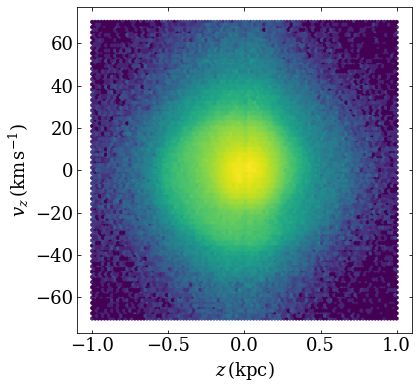

In [293]:
plt.figure(figsize=(6,6))
plt.hexbin(c.z,c.v_z,extent=[-1.,1.,-70.,70.],bins='log')
plt.xlabel(r'$z\,(\mathrm{kpc})$')
plt.ylabel(r'$v_z\,(\mathrm{km\,s}^{-1})$')

and the phase-space spiral when color-coding phase-space by $\langle v_T \rangle$:

Text(0, 0.5, '$v_z\\,(\\mathrm{km\\,s}^{-1})$')

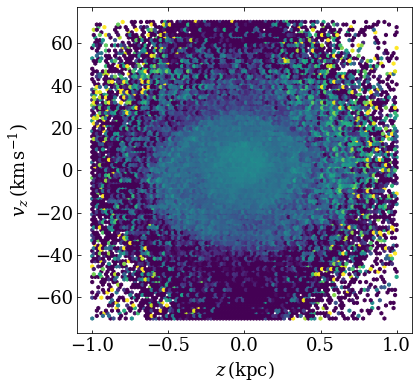

In [294]:
plt.figure(figsize=(6,6))
vT= -(c.represent_as('cylindrical')._differentials['s'].d_phi\
    *c.represent_as('cylindrical').rho).to_value(u.km/u.s,equivalencies=u.dimensionless_angles())
plt.hexbin(c.z,c.v_z,C=vT,extent=[-1.,1.,-70.,70.],vmin=210.,vmax=250.)
plt.xlabel(r'$z\,(\mathrm{kpc})$')
plt.ylabel(r'$v_z\,(\mathrm{km\,s}^{-1})$')

## The phase-space spiral in action-angle coordinates

Let's now convert the data to action-frequency-angle coordinates and see what we learn. To convert the data to action-angle coordinates, we load them into an `Orbit` instance and ask for the actions, frequencies, and angles:

In [295]:
o= Orbit(c)
jz= o.jz(pot=MWPotential2014)
Oz= o.Oz(pot=MWPotential2014)
az= o.wz(pot=MWPotential2014)
jr= o.jr(pot=MWPotential2014)
Or= o.Or(pot=MWPotential2014)
thetar= o.wr(pot=MWPotential2014)
phi=o.wp(pot=MWPotential2014)
R=o.R(pot=MWPotential2014)
vR = o.vR(pot=MWPotential2014)

/home/frankel/anaconda3/lib/python3.8/site-packages/galpy/actionAngle/actionAngleStaeckel_c.py:425: RuntimeWarning: invalid value encountered in remainder
  Anglephi[badAngle]= (Anglephi[badAngle] + phi[badAngle] % (2.*numpy.pi)) % (2.*numpy.pi)



Now again looking at the density in $(\theta_z,\Omega_z)$, we find

Text(0, 0.5, '$\\Omega_z\\,(\\mathrm{Gyr}^{-1})$')

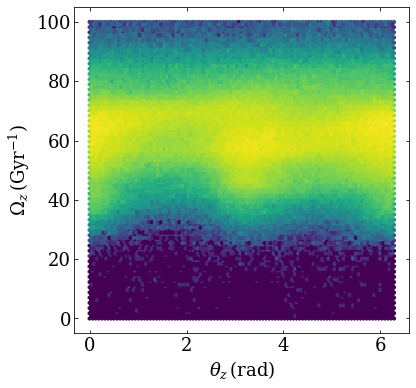

In [296]:
plt.figure(figsize=(6,6))
plt.hexbin(az,Oz,bins='log',extent=[0.,2.*numpy.pi,0.,100.])
plt.xlabel(r'$\theta_z\,(\mathrm{rad})$')
plt.ylabel(r'$\Omega_z\,(\mathrm{Gyr}^{-1})$')

and color-coding by $\langle L_z \rangle$, we find:

Text(0, 0.5, '$\\Omega_z\\,(\\mathrm{Gyr}^{-1})$')

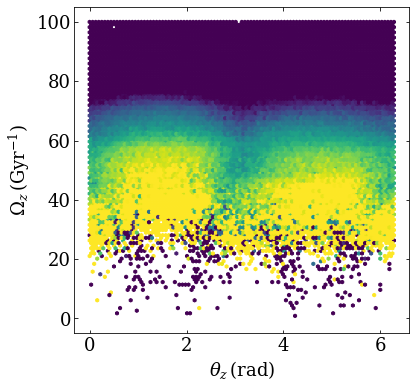

In [297]:
plt.figure(figsize=(6,6))
Lz= o.Lz()
plt.hexbin(az,Oz,C=Lz,extent=[0.,2.*numpy.pi,0.,100.],vmin=210.*8,vmax=250.*8)
plt.xlabel(r'$\theta_z\,(\mathrm{rad})$')
plt.ylabel(r'$\Omega_z\,(\mathrm{Gyr}^{-1})$')

<Figure size 432x288 with 0 Axes>

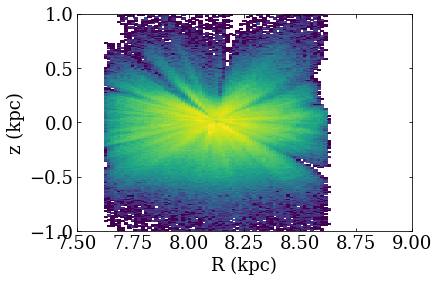

<Figure size 432x288 with 0 Axes>

In [298]:
jzbin = np.linspace(0,0.7,100)
zbin = np.linspace(-1,1,200)
Rbin = np.linspace(7.5,9,100)
plt.figure()
plt.hist2d(R, c.z.value, bins=(Rbin,zbin), density=1, norm=mpl.colors.LogNorm())
plt.xlabel('R (kpc)')
plt.ylabel('z (kpc)')
plt.figure()

#hz = np.mean(jz)/8
#plt.plot(np.exp(-jzbin/hz)/hz)

Now let's split the stars in angular momentum and make other selection cuts. Below I added a few cuts in JR, JZ and LZ. we see:
- vertical frequency is a function of both angular momentum and vertical action
- the phase space spiral shows in most Lz bins, apart from the lowest Lz bin, but that can be because there are only stars with high radial actions (at apocenter) in that bin
- again the $\theta_z$ distribution is highly non-uniform

Text(0, 0.5, '$J_z$ (kpc km/s)')

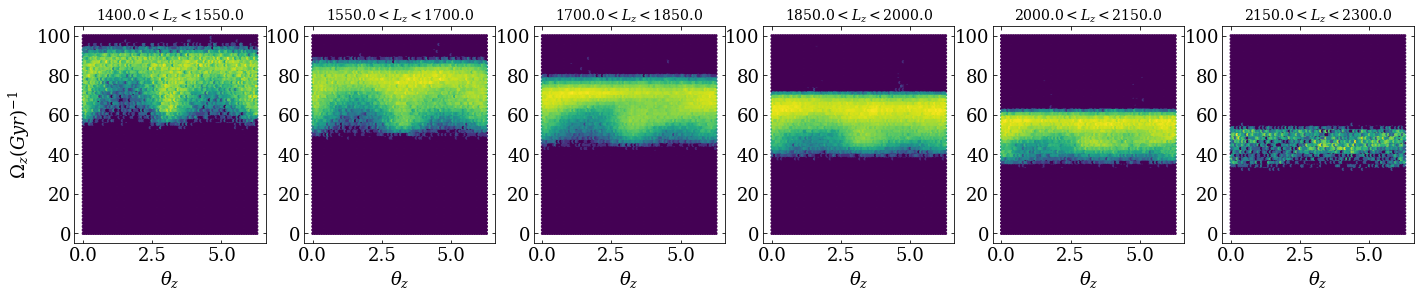

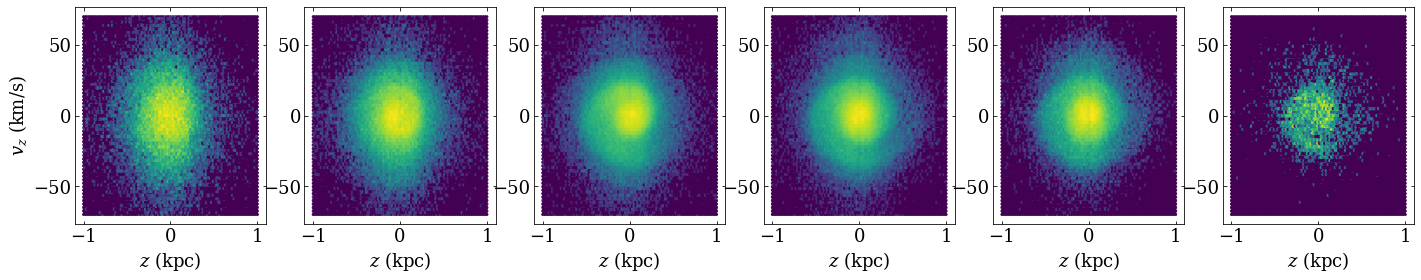

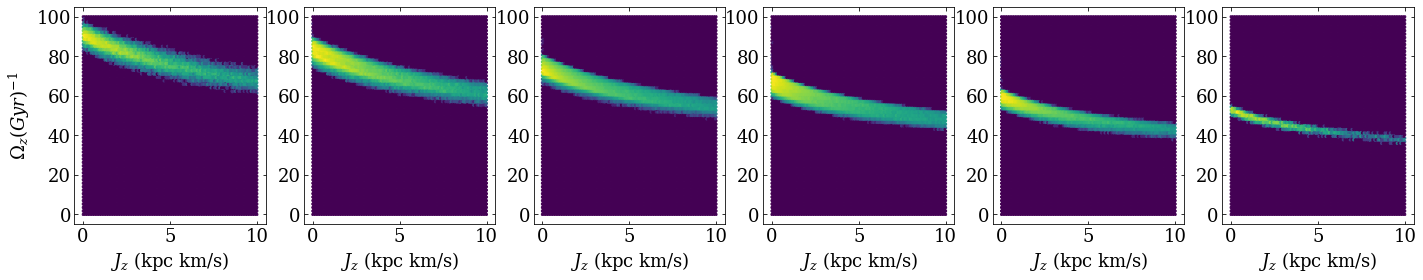

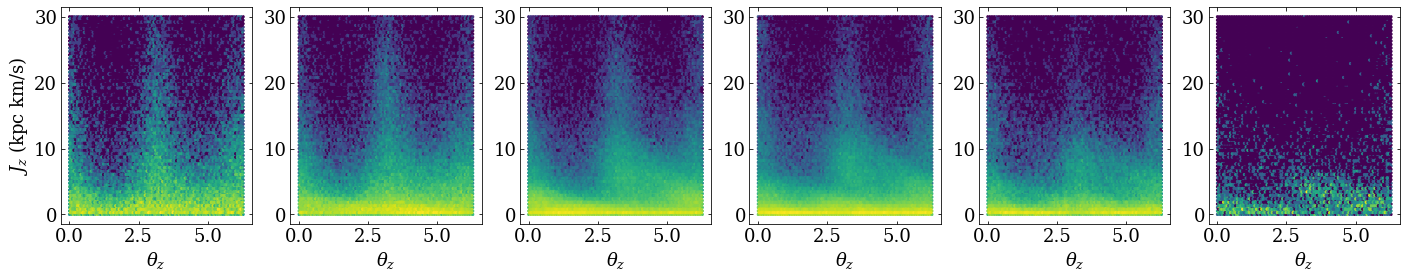

In [307]:
Nbins = 6
bLz = np.linspace(1400, 2300, Nbins+1)
fig, ax = plt.subplots(1,Nbins, figsize=(4*Nbins,4))

jrmax = 90
jrmin = 0
jzmax = 20

for i in range(Nbins):
    mask = (Lz > bLz[i]) & (Lz < bLz[i+1]) & (jr < jrmax) & (jz < jzmax)
    ax[i].hexbin(az[mask],Oz[mask],bins='log',extent=[0.,2.*numpy.pi,0.,100.])
    ax[i].set_title(str(bLz[i])+'$< L_z <$'+str(bLz[i+1]), fontsize=14)
for a in ax: a.set_xlabel(r'$\theta_z$')
ax[0].set_ylabel(r'$\Omega_z (Gyr)^{-1}$')
    
    
fig, ax = plt.subplots(1,Nbins, figsize=(4*Nbins,4))
for i in range(Nbins):
    mask = (Lz > bLz[i]) & (Lz < bLz[i+1]) & (jr < jrmax) & (jr > jrmin)
    ax[i].hexbin(c.z[mask],c.v_z[mask],bins='log',extent=[-1.,1.,-70.,70.])
for a in ax: a.set_xlabel(r'$z$ (kpc)')
ax[0].set_ylabel(r'$v_z$ (km/s)')    
    
fig, ax = plt.subplots(1,Nbins, figsize=(4*Nbins,4))
for i in range(Nbins):
    mask = (Lz > bLz[i]) & (Lz < bLz[i+1]) & (jr < jrmax)  & (jr > jrmin)
    ax[i].hexbin(jz[mask],Oz[mask],bins='log',extent=[0.,10.,0,100.])
for a in ax: a.set_xlabel(r'$J_z$ (kpc km/s)')
ax[0].set_ylabel(r'$\Omega_z (Gyr)^{-1}$')
    
fig, ax = plt.subplots(1,Nbins, figsize=(4*Nbins,4))
for i in range(Nbins):
    mask = (Lz > bLz[i]) & (Lz < bLz[i+1]) & (jr < jrmax) & (jr > jrmin)
    ax[i].hexbin(az[mask],jz[mask],bins='log',extent=[0.,2.*numpy.pi,0.,30.])
for a in ax: a.set_xlabel(r'$\theta_z$ ')
ax[0].set_ylabel(r'$J_z$ (kpc km/s)')

Text(0, 0.5, '$J_z$ (kpc km/s)')

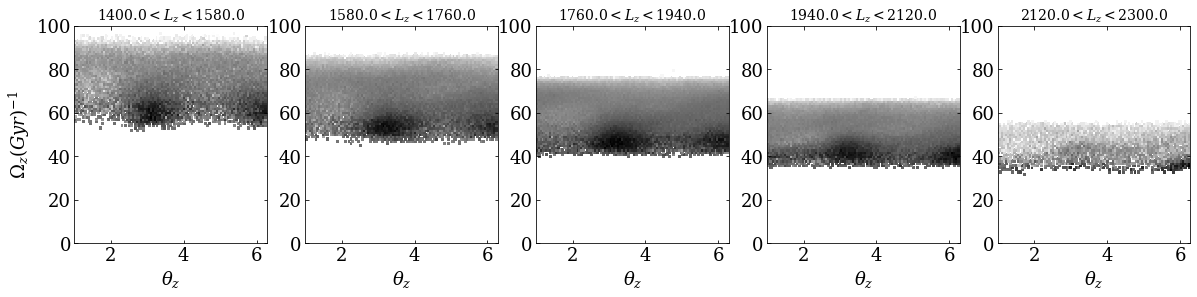

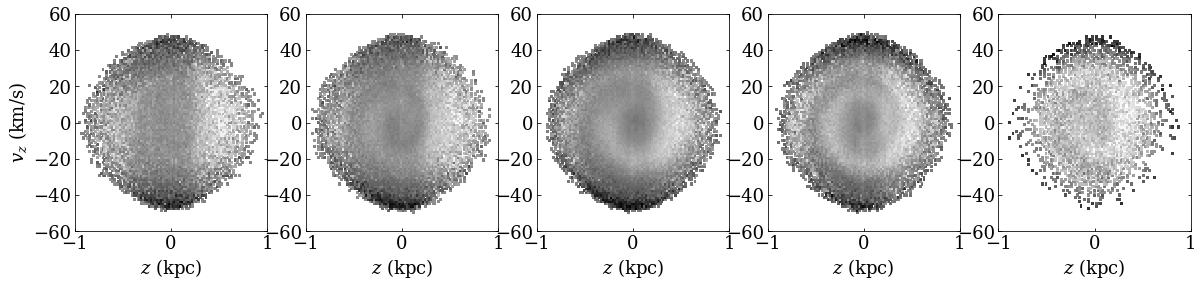

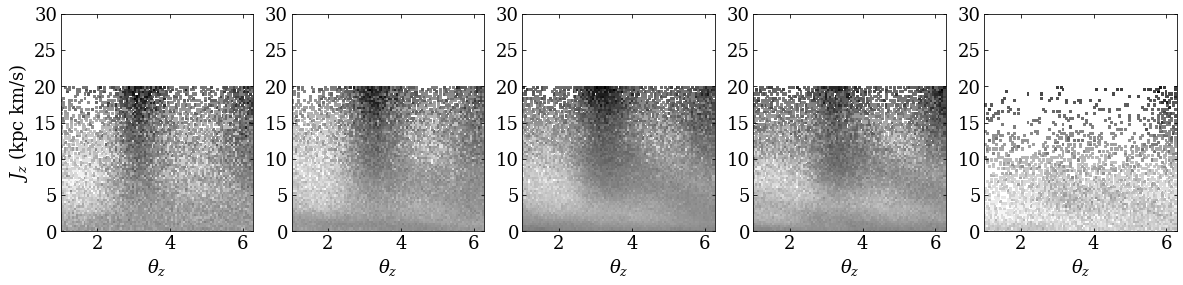

In [311]:
Nbins = 5
bLz = np.linspace(1400, 2300, Nbins+1)
fig, ax = plt.subplots(1,Nbins, figsize=(4*Nbins,4))

jrmax = 90
jrmin = 0
jzmax = 20

bang = np.linspace(1, 2*np.pi, 100)
bOz = np.linspace(0,100,100)
bz = np.linspace(-1,1,100)
bvz = np.linspace(-60,60,100)
bjz = np.linspace(0,30,100)

for i in range(Nbins):
    mask = (Lz > bLz[i]) & (Lz < bLz[i+1]) & (jr < jrmax)  & (jz < jzmax)
    ax[i].hist2d(az[mask],Oz[mask],bins=(bang, bOz), cmap='Greys', norm=mpl.colors.LogNorm(),
                weights=np.exp(jz[mask]/np.mean(jz[mask])*1.))
    ax[i].set_title(str(bLz[i])+'$< L_z <$'+str(bLz[i+1]), fontsize=14)
for a in ax: a.set_xlabel(r'$\theta_z$')
ax[0].set_ylabel(r'$\Omega_z (Gyr)^{-1}$')

fig, ax = plt.subplots(1,Nbins, figsize=(4*Nbins,4))
for i in range(Nbins):
    mask = (Lz > bLz[i]) & (Lz < bLz[i+1]) & (jr < jrmax) & (jz < jzmax)
    ax[i].hist2d(c.z.value[mask],c.v_z.value[mask],bins=(bz,bvz), weights=np.exp(jz[mask]/np.mean(jz[mask])*1.), 
                  norm=mpl.colors.LogNorm(),cmap='Greys')
for a in ax: a.set_xlabel(r'$z$ (kpc)')
ax[0].set_ylabel(r'$v_z$ (km/s)')    
    
    
fig, ax = plt.subplots(1,Nbins, figsize=(4*Nbins,4))
for i in range(Nbins):
    mask = (Lz > bLz[i]) & (Lz < bLz[i+1]) & (jr < jrmax) & (jr > jrmin)  & (jz < jzmax)
    ax[i].hist2d(az[mask],jz[mask],bins=(bang, bjz),  weights=np.exp(jz[mask]/np.mean(jz[mask])*1.),
                norm=mpl.colors.LogNorm(),cmap='Greys')
for a in ax: a.set_xlabel(r'$\theta_z$ ')
ax[0].set_ylabel(r'$J_z$ (kpc km/s)')

And redo the color-coding by vphi. Now, since the selection in radius has not changed, the selection in Lz imposes effectively a relation between vphi and R in each panel.

Text(0, 0.5, '$v_z$ (km/s)')

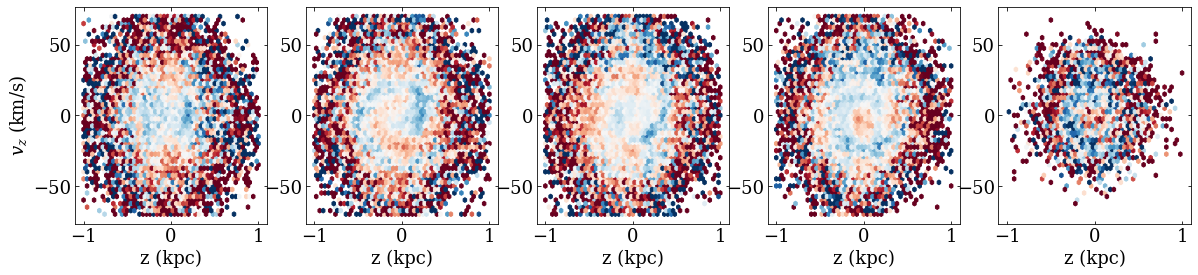

In [317]:
fig, ax = plt.subplots(1,Nbins, figsize=(4*Nbins,4))
for i in range(Nbins):
    mask = (Lz > bLz[i]) & (Lz < bLz[i+1]) & (jr < jrmax)  & (jr > jrmin)
    std = np.std(vT[mask])
    mean = np.mean(vT[mask])
    ax[i].hexbin(c.z[mask],c.v_z[mask],C=vT[mask],gridsize=50,extent=[-1.,1.,-70.,70.],vmin=mean-0.5*std,vmax=mean+0.5*std, cmap='RdBu')
for a in ax: a.set_xlabel(r'z (kpc)')
ax[0].set_ylabel(r'$v_z$ (km/s)')

Like Scott, we can compute $\theta_z'(t) = \theta_z - \Omega_z\,t$ and then look at $[\sum_i\cos(\theta'_{z,i}[t])]^2+[\sum_i\sin(\theta'_{z,i}[t])]^2$ where the sum is over all the stars in the sample. If there is a time for which all the angles $\theta'_{z,i}$ become similar, then this should be $\approx N^2$, so we divide by $N^2$ to normalize:

<ipython-input-320-5c14b43f5d82>:2: RuntimeWarning: invalid value encountered in multiply
  return az-Oz*t.to_value(u.Gyr)



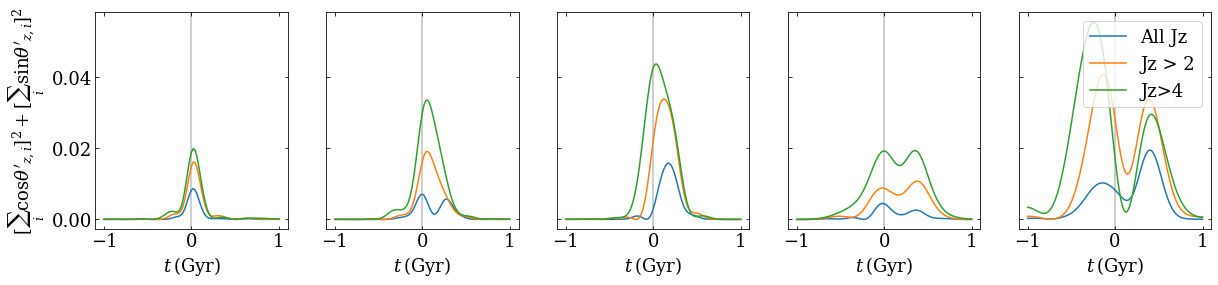

In [320]:
def thetapz(t,az=az,Oz=Oz):
    return az-Oz*t.to_value(u.Gyr)
ts= numpy.linspace(-1.,1.,101)*u.Gyr

fig, ax = plt.subplots(1,Nbins, figsize=(4*Nbins,4), sharey=True)
for i in range(Nbins):
    mjz = (Lz > bLz[i]) & (Lz < bLz[i+1]) & (jr < jrmax)  
    mjz1 = (Lz > bLz[i]) & (Lz < bLz[i+1]) & (jr < jrmax) & (jz > 2)
    mjz2 = (Lz > bLz[i]) & (Lz < bLz[i+1]) & (jr < jrmax) & (jz > 4)
    ax[i].plot(ts,
         [(numpy.nansum(numpy.cos(thetapz(t, az[mjz], Oz[mjz])))**2.
          +numpy.nansum(numpy.sin(thetapz(t, az[mjz], Oz[mjz])))**2.)/len(az[mjz])**2. for t in ts],
              label='All Jz')
    ax[i].plot(ts,
         [(numpy.nansum(numpy.cos(thetapz(t, az[mjz1], Oz[mjz1])))**2.
          +numpy.nansum(numpy.sin(thetapz(t, az[mjz1], Oz[mjz1])))**2.)/len(az[mjz1])**2. for t in ts],
              label='Jz > 2')
    
    ax[i].plot(ts,
         [(numpy.nansum(numpy.cos(thetapz(t, az[mjz2], Oz[mjz2])))**2.
          +numpy.nansum(numpy.sin(thetapz(t, az[mjz2], Oz[mjz2])))**2.)/len(az[mjz2])**2. for t in ts],
              label='Jz>4')
    
    ax[i].axvline(0.,color='0.75',zorder=-1)
for a in ax: a.set_xlabel(r'$t\,(\mathrm{Gyr})$')
ax[0].set_ylabel(r"$[\sum_i \cos \theta'_{z,i}]^2+[\sum_i \sin \theta'_{z,i}]^2$")
plt.legend()

The time of maximum depends on both angular momentum and vertical action. Also, stars with higher Jz seem to have a stronger signal than those with low Jz. In the plots above, the $\theta_z$ distribution of low $J_z$ stars look more uniform. Similarly, in the z-vz plane low Jz stars correspond to the central blob that is well centered on (0,0) at t=0.


The signal above tells how lopsided the $\theta_z$ distribution is. But overall, the $\theta_z$ distribution is very much not uniform and there seem to be a non-negligible signal in $2\theta_z$. Take an angular momentum bin below and show $p(\theta_z)$

Text(0.5, 0, '$\\theta_z$')

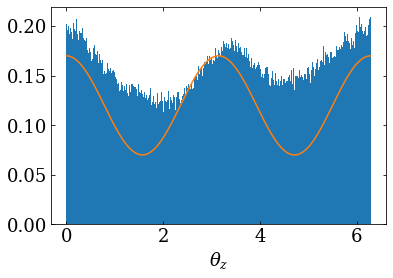

In [323]:
mjz = (Lz > bLz[2]) & (Lz < bLz[3])
bthetaz = numpy.linspace(0,2*numpy.pi, 400)
plt.hist(az[mjz], bins=bthetaz, density=1)
plt.plot(bthetaz, 0.05*np.cos(2*bthetaz) + 0.12)
plt.xlabel(r'$\theta_z$')

<ipython-input-320-5c14b43f5d82>:2: RuntimeWarning: invalid value encountered in multiply
  return az-Oz*t.to_value(u.Gyr)



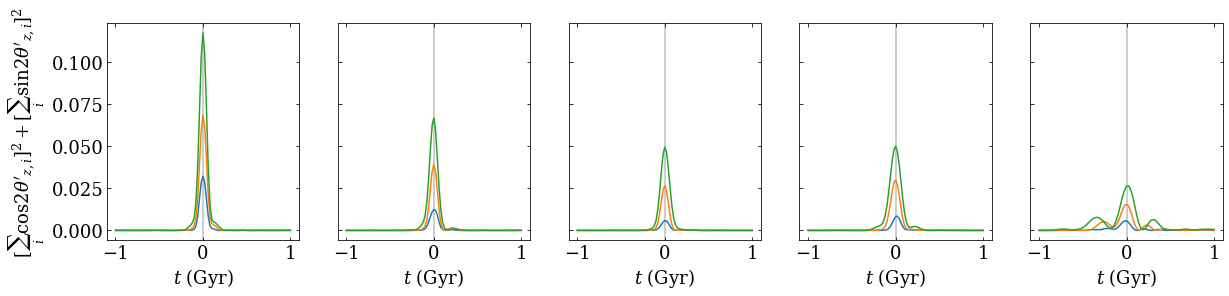

In [322]:
m = 2

fig, ax = plt.subplots(1,Nbins, figsize=(4*Nbins,4), sharey=True)
for i in range(Nbins):
    mjz = (Lz > bLz[i]) & (Lz < bLz[i+1]) & (jr < jrmax)  #& (jz > 1)
    mjz1 = (Lz > bLz[i]) & (Lz < bLz[i+1]) & (jr < jrmax) & (jz > 2)
    mjz2 = (Lz > bLz[i]) & (Lz < bLz[i+1]) & (jr < jrmax) & (jz > 4)
    ax[i].plot(ts,
         [(numpy.nansum(numpy.cos(m*thetapz(t, az[mjz], Oz[mjz])))**2.
          +numpy.nansum(numpy.sin(m*thetapz(t, az[mjz], Oz[mjz])))**2.)/len(az[mjz])**2. for t in ts])
    ax[i].plot(ts,
         [(numpy.nansum(numpy.cos(m*thetapz(t, az[mjz1], Oz[mjz1])))**2.
          +numpy.nansum(numpy.sin(m*thetapz(t, az[mjz1], Oz[mjz1])))**2.)/len(az[mjz1])**2. for t in ts])
    
    ax[i].plot(ts,
         [(numpy.nansum(numpy.cos(m*thetapz(t, az[mjz2], Oz[mjz2])))**2.
          +numpy.nansum(numpy.sin(m*thetapz(t, az[mjz2], Oz[mjz2])))**2.)/len(az[mjz2])**2. for t in ts])
    
    ax[i].axvline(0.,color='0.75',zorder=-1)
ax[0].set_xlabel(r'$t\,(\mathrm{Gyr})$')
ax[0].set_ylabel(r"$[\sum_i \cos 2\theta'_{z,i}]^2+[\sum_i \sin 2\theta'_{z,i}]^2$")
for a in ax: a.set_xlabel(r'$t$ (Gyr)')

<ipython-input-320-5c14b43f5d82>:2: RuntimeWarning: invalid value encountered in multiply
  return az-Oz*t.to_value(u.Gyr)



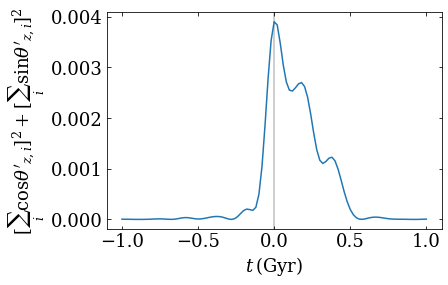

In [324]:
plt.plot(ts,
         [(numpy.nansum(numpy.cos(thetapz(t, az, Oz)))**2.
          +numpy.nansum(numpy.sin(thetapz(t, az, Oz)))**2.)/len(az)**2. for t in ts])
plt.xlabel(r'$t\,(\mathrm{Gyr})$')
plt.ylabel(r"$[\sum_i \cos \theta'_{z,i}]^2+[\sum_i \sin \theta'_{z,i}]^2$");
plt.axvline(0.,color='0.75',zorder=-1)

There is a broad peak at zero and no signal beyond 0.5 Gyr.

## A quick look at a similation

To see how these things play out in a simulation, we can simulation the evolution of a perturbation in the vertical phase space using [wendy](https://github.com/jobovy/wendy), a one-dimensional N-body code. We follow the [Gaia phase-space spiral example](https://nbviewer.org/github/jobovy/wendy/blob/master/examples/GaiaPhaseSpaceSpiral.ipynb?flush_cache=true). Note that `wendy` is currently somewhat tricky to install, because it requires `numba`, which only works for `numpy` versions < 1.21.

We'll just copy a bunch of code from the [Gaia phase-space spiral example](https://nbviewer.org/github/jobovy/wendy/blob/master/examples/GaiaPhaseSpaceSpiral.ipynb?flush_cache=true). See that notebook for more info on the steps (to avoid confusion, we work in units where $G=1$ here rather than $2\pi G = 1$ as in the `wendy` example):

In [10]:
import numpy
import tqdm
import wendy

Set up an isothermal disk:

In [11]:
# Initial disk
N= 100000
# compute zh based on sigma and totmass
totmass= 1. # Sigma above
sigma= 1.
zh= sigma**2./totmass/2./numpy.pi # G = 1. in wendy units
tdyn= zh/sigma
x= numpy.arctanh(2.*numpy.random.uniform(size=N)-1)*zh*2.
v= numpy.random.normal(size=N)*sigma
v-= numpy.mean(v) # stabilize
m= totmass*numpy.ones_like(x)/N

Make only a fraction of it live:

In [12]:
alpha= 0.3 # "live" fraction
# Adjust masses to only represent alpha of the mass
m*= alpha
# 1-alpha in the mass is then given by the external force
sigma2= sigma**2.
def iso_force(x,t):
    return -(1.-alpha)*sigma2*numpy.tanh(0.5*x/zh)/zh

Perturb the disk by offsetting by $1\sigma$ in velocity:

In [13]:
v+= sigma

Set up and run the simulation for 50 dynamical times:

In [14]:
g= wendy.nbody(x,v,m,0.05*tdyn,nleap=10,approx=True,
               sort='tim',ext_force=iso_force,twopiG=2.*numpy.pi)
nt= 1000
xt= numpy.empty((N,nt+1))
vt= numpy.empty((N,nt+1))
xt[:,0]= x
vt[:,0]= v
for ii in tqdm.trange(nt):
    tx,tv= next(g)
    xt[:,ii+1]= tx
    vt[:,ii+1]= tv

100%|██████████| 1000/1000 [00:58<00:00, 17.05it/s]


The phase-space density is strongly perturbed:

Text(0, 0.5, '$v_z$')

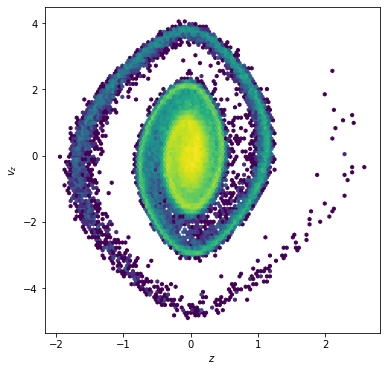

In [15]:
plt.figure(figsize=(6,6))
plt.hexbin(xt[:,-1],vt[:,-1],bins='log')
plt.xlabel(r'$z$')
plt.ylabel(r'$v_z$')

Now we compute the frequencies and angles in this simulation. We do this using the 1D action-angle calculator that is included in `galpy`. However, note that the frequencies and angles of this calculator is not exposed to users currently and I had to fix some indexing bugs to make this work. So this doesn't work with any `galpy` release (however, the calculation is straightforward).

First we set up the isothermal disk as a 1D potential, making sure that the amplitude is the same as that used above:

In [16]:
from galpy.potential import IsothermalDiskPotential
from galpy.actionAngle import actionAngleVertical
ip= IsothermalDiskPotential(amp=numpy.pi/2.*totmass**2./sigma**2.,sigma=sigma)

Then we compute frequencies and angles:

In [17]:
sim_Oz= []
sim_az= []
for ii in tqdm.trange(len(x)):
    taAV= actionAngleVertical.actionAngleVertical(0.,0.,0.,xt[ii,-1],vt[ii,-1],pot=ip)
    sim_Oz.append(2.*numpy.pi/taAV.Tz())
    sim_az.append(taAV.anglez())
sim_Oz= numpy.array(sim_Oz)
sim_az= numpy.array(sim_az)

 11%|█▏        | 11277/100000 [00:21<02:51, 517.94it/s]

/Users/bovy/Repos/galpy/galpy/actionAngle/actionAngleVertical.py:106: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  self._anglez= 2.*numpy.pi*integrate.quad(_TzIntegrand,0.,numpy.fabs(self._z),



 23%|██▎       | 23340/100000 [00:44<02:24, 532.09it/s]

/Users/bovy/Repos/galpy/galpy/actionAngle/actionAngleVertical.py:83: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  self._Tz= 4.*integrate.quad(_TzIntegrand,0.,zmax,



100%|██████████| 100000/100000 [03:13<00:00, 518.01it/s]


Now we can compute $\theta_z'(t) = \theta_z - \Omega_z\,t$ and $[\sum_i\cos(\theta'_{z,i}[t])]^2+[\sum_i\sin(\theta'_{z,i}[t])]^2$ as before and plot it:

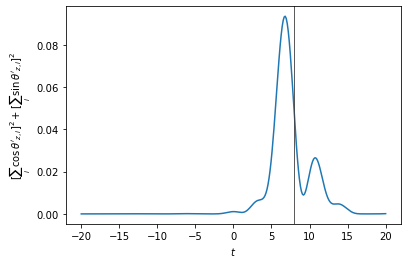

In [18]:
def thetapz(t,az=sim_az,Oz=sim_Oz):
    return az-Oz*t
ts= numpy.linspace(-20.,20.,301)
plt.plot(ts,
         [(numpy.nansum(numpy.cos(thetapz(t)))**2.
          +numpy.nansum(numpy.sin(thetapz(t)))**2.)/len(sim_az)**2. for t in ts])
plt.xlabel(r'$t$')
plt.ylabel(r"$[\sum_i \cos \theta'_{z,i}]^2+[\sum_i \sin \theta'_{z,i}]^2$")
plt.axvline(1000*0.05*tdyn,color='0.25',lw=0.85);

We see that there is now a peak at roughly the correct time (the correct time is indicated by the vertical time). However, the peak is quite broad and slightly offset. The offset might be because the perturbed disk's gravitational potential deviates from the initial isothermal potential used to compute the frequencies and angles.

To see whether the width of the peak and the low amplitude is due to the initial condition of the perturbation having these properties, let's compute $[\sum_i\cos(\theta'_{z,i}[t])]^2+[\sum_i\sin(\theta'_{z,i}[t])]^2$ for the initial condition:

In [19]:
sim_Oz_orig= []
sim_az_orig= []
for ii in tqdm.trange(len(x)):
    taAV= actionAngleVertical.actionAngleVertical(0.,0.,0.,xt[ii,0],vt[ii,0],pot=ip)
    sim_Oz_orig.append(2.*numpy.pi/taAV.Tz())
    sim_az_orig.append(taAV.anglez())
sim_Oz_orig= numpy.array(sim_Oz_orig)
sim_az_orig= numpy.array(sim_az_orig)

  9%|▉         | 9294/100000 [00:17<02:50, 533.40it/s]

/Users/bovy/Repos/galpy/galpy/actionAngle/actionAngleVertical.py:106: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  self._anglez= 2.*numpy.pi*integrate.quad(_TzIntegrand,0.,numpy.fabs(self._z),



 19%|█▊        | 18595/100000 [00:34<02:29, 545.41it/s]

/Users/bovy/Repos/galpy/galpy/actionAngle/actionAngleVertical.py:83: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  self._Tz= 4.*integrate.quad(_TzIntegrand,0.,zmax,



100%|██████████| 100000/100000 [03:07<00:00, 532.77it/s]


and here's the plot (peak should now be at $t=0$):

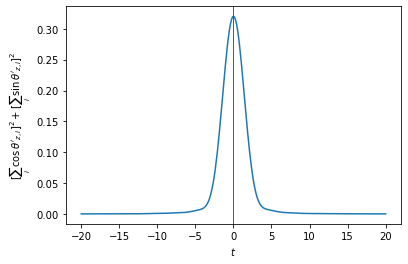

In [21]:
def thetapz(t,az=sim_az_orig,Oz=sim_Oz_orig):
    return az-Oz*t
ts= numpy.linspace(-20.,20.,301)
plt.plot(ts,
         [(numpy.nansum(numpy.cos(thetapz(t)))**2.
          +numpy.nansum(numpy.sin(thetapz(t)))**2.)/len(sim_az)**2. for t in ts])
plt.xlabel(r'$t$')
plt.ylabel(r"$[\sum_i \cos \theta'_{z,i}]^2+[\sum_i \sin \theta'_{z,i}]^2$")
plt.axvline(0*0.05*tdyn,color='0.25',lw=0.85);

The width of the peak for the initial condition is quite similar to that for the final snapshot, but the amplitude is about three times higher. But overall the properties of the final peak are not so different from those of the initial peak.